In [26]:
import os

import pandas as pd
import numpy as np
import umap
import math
import random

from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.utils import shuffle

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import torch.optim as optim

import time
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import seaborn as sns

# model
from convnetvae.models import *
from convnetvae.utilities import *

### Parameter setup

In [9]:
dataSet = 'nano_ct_mouse_brain_ATAC_H3K27ac_H3K27me3_bin10kb'
countDist = 'Poisson'
learningRate=1e-3
numEpochs=300
batchSize=128
numFeature=25000
dimLatent=30
numHiddenUnits=128
modalityList=['ATAC','H3K27ac', 'H3K27me3']
includeWNN=False
numSample=2
numChannel=[32]
sizeConvKernel=31
sizeStrideEnc=31
numKFolds=1
foldStratifyOption=None
dropoutRate=0.2
numModality=len(modalityList)
randomSeed = 2023

### Select proper model architecture
Here we choose single-Conv1D-layer model for demo

In [3]:
if len(numChannel) == 1:
    ConvNetVAE = ConvNetL1VAE
if len(numChannel) == 2:
    ConvNetVAE = ConvNetL2VAE
if len(numChannel) == 3:
    ConvNetVAE = ConvNetL3VAE

### Load nano-ct juvenile mouse brain dataset (tri-modal)
Epigenomic modalities included: ATAC, H3K27ac, H3K27me3

In [4]:
if dataSet == 'nano_ct_mouse_brain_ATAC_H3K27ac_H3K27me3_bin10kb':
    input_prep = input_prep_nano_ct_mouse_brain_ATAC_H3K27ac_H3K27me3_bin10kb
    batch_correct = '_batchCorrect'
    
# Load datasets
if numModality == 1:
    omics_data, batch_code_one_hot, cell_idx, annot_file_dict, celltype_code_dict = input_prep()
else:
    omics_data, batch_code_one_hot, cell_idx, annot_file_dict, celltype_code_dict = input_prep(includeWNN, modalityList,numSample)

model_input = TensorDataset(Tensor(omics_data), 
                            batch_code_one_hot,
                            Tensor(cell_idx).long())
print(f'Input tensor ready.')

Including WNN labels for evaluation.
Input data loading completed. Dimension: (4434, 3, 25000)
Input tensor ready.


### Run ConvNet-VAE
In this demo, we showcase a single-Conv1D-layer ConvNet-VAE with kernel size of 31 and stride of 31 to integrate the entire tri-modal single-cell epigenomic data.

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [6]:
# dicts for saving results
modality_list = modalityList
print(f'Modalities for analysis: {" ".join(modality_list)}')

Modalities for analysis: ATAC H3K27ac H3K27me3


In [11]:
# Set random number seed
seed = randomSeed
seed_everything(seed)
print(f'Random seed: {seed}')

G = torch.Generator()
G.manual_seed(seed)

# Define sampler
train_subsampler = SubsetRandomSampler(list(range(omics_data.shape[0])), generator=G)

# Data loaders for traning and validation sets      
params = {'batch_size': batchSize,
          'shuffle': False,
          'num_workers': 0,
          'drop_last': True}
params_eval = {'batch_size': batchSize,
          'shuffle': False,
          'num_workers': 0,
          'drop_last': False}
train_loader = DataLoader(model_input, sampler=train_subsampler, **params)
train_eval_loader = DataLoader(model_input, **params_eval)

# Initialize model
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
convnetvae_model = ConvNetVAE(num_feature=numFeature,
                              count_dist=countDist,
                              num_modality=numModality,
                              num_sample=numSample,
                              dim_latent=dimLatent,
                              num_hidden_units=numHiddenUnits,
                              num_channel=numChannel,
                              size_conv_kernel=sizeConvKernel, 
                              size_stride=sizeStrideEnc, 
                              dropout_rate=dropoutRate).to(device)

print(f'Total number of trainable params: {count_model_parameters(convnetvae_model)}')

# Reset model
convnetvae_model.apply(reset_model_weights)
print('Model reset completed.')

# Initialize optimizer
optimizer = optim.Adam(convnetvae_model.parameters(), lr=learningRate)

# ConvNetVAE training
epoch_tracker = []
train_loss_tracker = []
valid_loss_tracker = []

print('Training starts...')
convnetvae_model.train()

# Model Traning
start_time_train = time.time()
for epoch in tqdm(range(1, numEpochs+1)):
    train_overall_loss = 0.0
    convnetvae_model.train()
    for batch, (cell_data, batch_id, _) in enumerate(train_loader):
        cell_data = cell_data.to(device)
        batch_id = batch_id.to(device)
        optimizer.zero_grad() # zero the parameter gradients›
        inference_outputs, generative_outputs, loss = convnetvae_model(cell_data, batch_id) 
        train_overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_avg_loss = train_overall_loss / ((batch+1)*batchSize)
    train_loss_tracker.append(train_avg_loss)
    epoch_tracker += [epoch + 1]
runtime = time.time() - start_time_train
print('Training completed.')

latent_z_train = []
latent_z_valid = []
qz_x_var_train = []
qz_x_var_valid = []
cell_idx_train_eval_fold = []
cell_idx_valid_eval_fold = []
convnetvae_model.eval()
sample_z = False

# Obtain cell embeddings from training set
with torch.no_grad():
    overall_loss = 0.0
    for data in train_eval_loader: # training set
        cell_data, batch_id, cell_idx = data
        cell_idx_train_eval_fold += cell_idx.tolist()
        cell_data = cell_data.to(device)
        batch_id = batch_id.to(device)

        inference_outputs, generative_outputs, loss = convnetvae_model(cell_data, batch_id)
        overall_loss += loss.item()

        qz_x_mean = inference_outputs['qz_x_mean']
        qz_x_var = inference_outputs['qz_x_var']

        if sample_z:
            samples = Normal(qz_x_mean, qz_x_var.sqrt()).sample([1000]) # sample 1000 values
            z = nn.Softmax(dim=-1)(samples)
            z = z.mean(dim=0)
        else:
            z = qz_x_mean 

        latent_z_train += [z.cpu()]
        qz_x_var_train += [qz_x_var.cpu()]

avg_loss = overall_loss / len(cell_idx_train_eval_fold)
print('Average Loss (Training set): ', avg_loss)

cell_latent_representation_train = np.array(torch.cat(latent_z_train))
print('Cell latent representation (Training set) obtained.')

Random seed: 2023
Total number of trainable params: 4172095
Model reset completed.
Training starts...


100%|██████████| 300/300 [28:30<00:00,  5.70s/it]


Training completed.
Average Loss (Training set):  191.48031766252257
Cell latent representation (Training set) obtained.


### UMAP visualization

In [20]:
cell_latent_representation_df_train = pd.DataFrame(cell_latent_representation_train)
umap_coords = umap.UMAP(n_neighbors=30, # 30
                        min_dist=0.4, # 0.4
                        metric='cosine',
                        random_state=2023).fit_transform(cell_latent_representation_df_train)

folder_path = 'demo_results/ConvNet'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
np.save(os.path.join(folder_path,'z_batchCorrect_convNetVAE_L1_K31S31_seed'+str(seed)), cell_latent_representation_train)
np.save(os.path.join(folder_path,'umap_coords_batchCorrect_convNetVAE_L1_K31S31_seed'+str(seed)), umap_coords)

In [21]:
data_directory = 'datasets/'
data_collection = 'nano_ct_mouse_brain'

# load batch info
batch_info_file = 'nano_ct_mouse_brain_ATAC_H3K27ac_H3K27me3_batch_info.csv'
batch_info_file_path = os.path.join(data_directory, data_collection, batch_info_file)
batch_id_info = pd.read_csv(batch_info_file_path, sep='\t')

# load cell type info (WNN label)
annot_file = 'nano_ct_mouse_brain_WNN_cell_type_l3.csv' 
celltype_pd = pd.read_csv(os.path.join(data_directory, data_collection, annot_file), sep='\t')

In [22]:
umap_coords_pd = pd.DataFrame(umap_coords)
umap_coords_pd.columns = ['UMAP1','UMAP2']
umap_coords_pd['Batch'] = batch_id_info.batch.values
umap_coords_pd['Celltype'] = celltype_pd.ann.values

#### Colored by batch labels

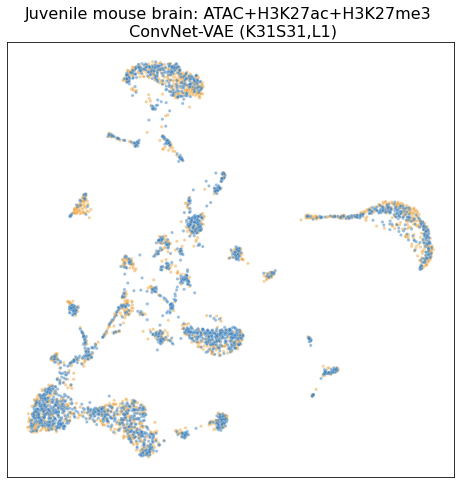

In [33]:
plt.figure(figsize=(8,8))
sns.set_palette(['#EEA236FF','#357EBDFF'])
p = sns.scatterplot(data=umap_coords_pd, x='UMAP1', y='UMAP2', hue='Batch', alpha=0.5, s=10)
p.set(xticklabels=[]) 
p.set(yticklabels=[])
p.set(xlabel=None)
p.set(ylabel=None)
p.tick_params(bottom=False, left=False)
p.set_title('Juvenile mouse brain: ATAC+H3K27ac+H3K27me3 \n ConvNet-VAE (K31S31,L1)', fontsize = 16)
plt.legend([],[], frameon=False)

plt.savefig(os.path.join(folder_path,'umap_ATAC_H3K27ac_H3k27me3_convNetVAE_L1_K31S31_after_batchCorrect_seed2023.png'),dpi=(300), bbox_inches='tight')
plt.show()

#### Colored by annotations

In [29]:
palette_cat20 = ['#1F77B4FF','#FF7F0EFF','#2CA02CFF','#D62728FF','#9467BDFF','#8C564BFF','#E377C2FF','#7F7F7FFF','#BCBD22FF',
                 '#17BECFFF','#AEC7E8FF','#FFBB78FF','#98DF8AFF','#FF9896FF','#C5B0D5FF','#C49C94FF','#F7B6D2FF','#C7C7C7FF',
                 '#DBDB8DFF','#9EDAE5FF']

In [31]:
umap_coords_pd['ann'] = celltype_pd.ann.values
unique_celltype = umap_coords_pd['ann'].unique()

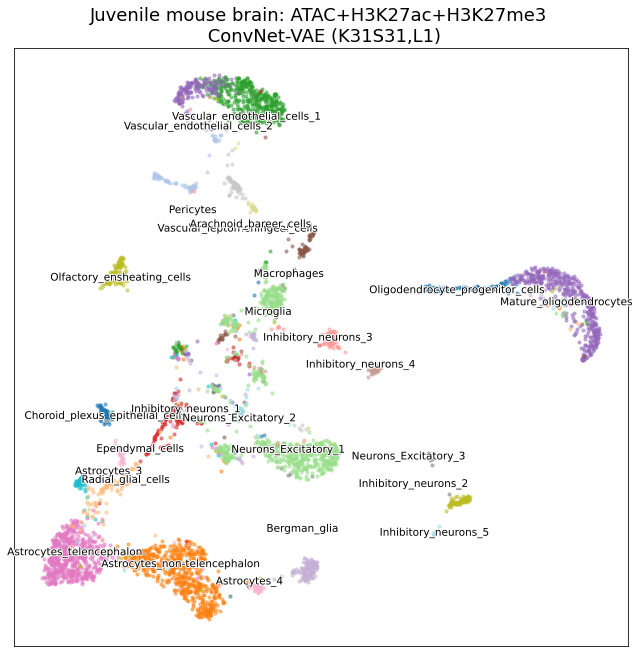

In [32]:
plt.figure(figsize=(11,11))

cmap = matplotlib.colors.ListedColormap(palette_cat20)
colors = cmap(np.linspace(0, 1.0, len(unique_celltype)))

for celltype, color in zip(unique_celltype, colors):
    plt.scatter(umap_coords_pd.loc[umap_coords_pd['ann']==celltype,'UMAP1'], 
                umap_coords_pd.loc[umap_coords_pd['ann']==celltype,'UMAP2'], 
                label=celltype,
                color=color,
                alpha=0.50,
                s=10)
    
    plt.annotate(celltype, 
                (umap_coords_pd.loc[umap_coords_pd['ann']==celltype,'UMAP1'].mean(),
                 umap_coords_pd.loc[umap_coords_pd['ann']==celltype,'UMAP2'].mean()),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=10.5, #weight='bold',
                 path_effects=[patheffects.withStroke(linewidth=2, foreground='white', capstyle="round")]) #15
plt.title('Juvenile mouse brain: ATAC+H3K27ac+H3K27me3 \n ConvNet-VAE (K31S31,L1)', fontsize=18) 
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.savefig(os.path.join(folder_path,'umap_ATAC_H3K27ac_H3k27me3_convNetVAE_L1_K31S31_seed2023_annotated.png'),dpi=(300), bbox_inches='tight')
plt.show()